## 1. Import Library
Notebook ini mengimplementasikan 3 model neural network untuk data tabular:
- MLP (Non-Pretrained)
- TabNet (Pretrained)
- Pretrained embedding + Neural Network


In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn torch pytorch-tabnet

Defaulting to user installation because normal site-packages is not writeable


## 2. Import library dan load data

Dataset merupakan data tabular dengan 445.132 baris dan 40 fitur.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

df = pd.read_csv('heart_2022_with_nans.csv')

In [15]:
df.describe

<bound method NDFrame.describe of         State  Sex  GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0           0    0              4                 0.0               0.0   
1           0    0              0                 0.0               0.0   
2           0    0              4                 2.0               3.0   
3           0    0              0                 0.0               0.0   
4           0    0              1                 2.0               0.0   
...       ...  ...            ...                 ...               ...   
445127     48    0              2                 0.0               3.0   
445128     48    0              0                 2.0               2.0   
445129     48    0              3                30.0              30.0   
445130     48    1              4                 0.0               0.0   
445131     48    1              4                 0.0               1.0   

        LastCheckupTime  PhysicalActivities  SleepHours  RemovedT

In [5]:
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


## 3. EDA
Target klasifikasi yang digunakan adalah **HadHeartAttack**.


C:\Users\an466\AppData\Local\Temp\ipykernel_2992\1551769648.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='HadHeartAttack', data=df, palette='viridis')


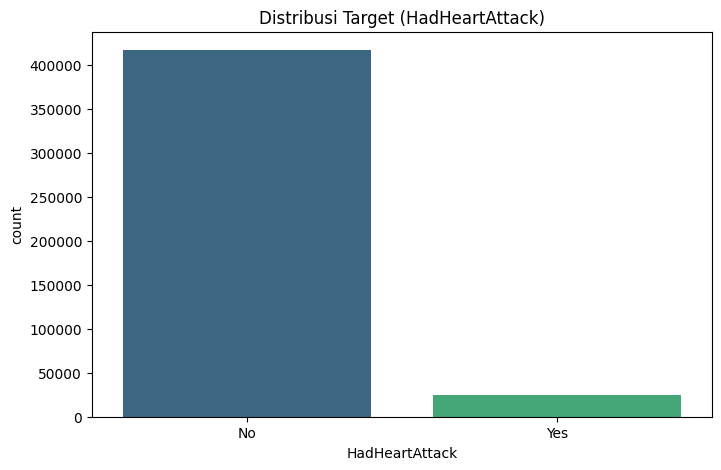

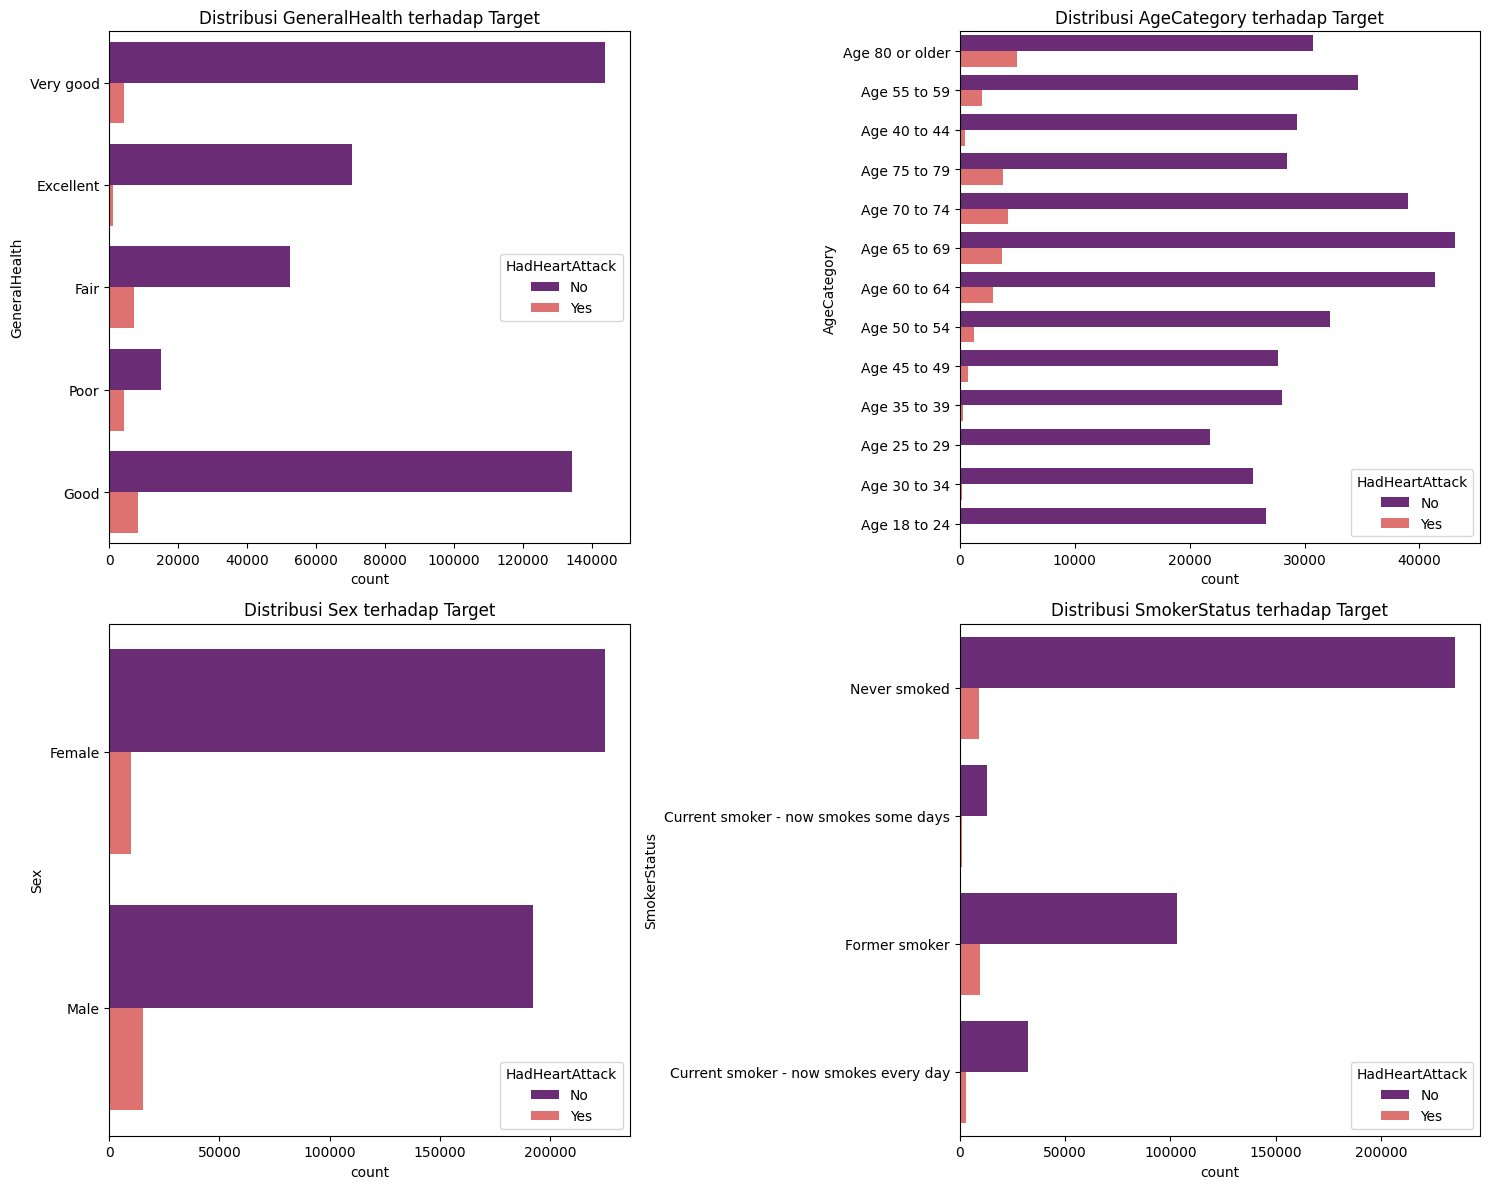

C:\Users\an466\AppData\Local\Temp\ipykernel_2992\1551769648.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HadHeartAttack', y='BMI', data=df, palette='Set2')


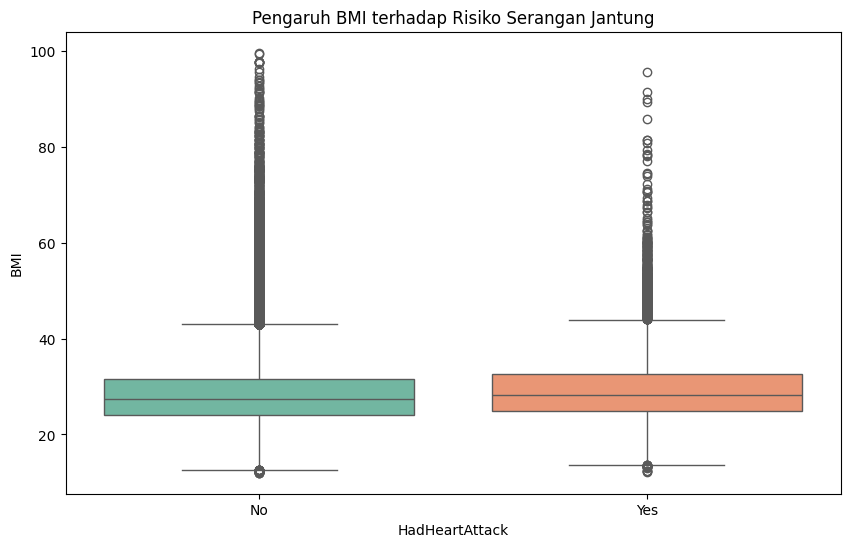

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='HadHeartAttack', data=df, palette='viridis')
plt.title('Distribusi Target (HadHeartAttack)')
plt.show()

key_features = ['GeneralHealth', 'AgeCategory', 'Sex', 'SmokerStatus']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, col in enumerate(key_features):
    sns.countplot(y=col, hue='HadHeartAttack', data=df, ax=axes[i//2, i%2], palette='magma')
    axes[i//2, i%2].set_title(f'Distribusi {col} terhadap Target')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='HadHeartAttack', y='BMI', data=df, palette='Set2')
plt.title('Pengaruh BMI terhadap Risiko Serangan Jantung')
plt.show()

## 4. Preprocessing



In [7]:
target_col = 'HadHeartAttack'
df = df.dropna(subset=[target_col])

numeric_cols = df.select_dtypes(include=['float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns.drop(target_col)

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col].astype(str))

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = class_weights.to(device)

X_train_t = torch.tensor(X_train_scaled.astype(np.float32)).to(device)
y_train_t = torch.tensor(y_train.values.astype(np.int64)).to(device)
X_val_t = torch.tensor(X_val_scaled.astype(np.float32)).to(device)
y_val_t = torch.tensor(y_val.values.astype(np.int64)).to(device)
X_test_t = torch.tensor(X_test_scaled.astype(np.float32)).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=1024, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=1024)

C:\Users\an466\AppData\Local\Temp\ipykernel_2992\1974625917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].median())
C:\Users\an466\AppData\Local\Temp\ipykernel_2992\1974625917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].median())
C:\Users\an466\AppData\Local\Temp\ipykernel_2992\1974625917.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

# 5. MLP

## 5.1 Train Model

In [8]:
class BaseMLP(nn.Module):
    def __init__(self, input_dim):
        super(BaseMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = BaseMLP(X_train_scaled.shape[1]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

mlp_history = {'loss': [], 'acc': []}

for epoch in range(15):
    mlp_model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        loss = criterion(mlp_model(batch_x), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    mlp_model.eval()
    with torch.no_grad():
        preds = torch.max(mlp_model(X_val_t), 1)[1]
        acc = (preds == y_val_t).float().mean().item()
    
    mlp_history['loss'].append(total_loss/len(train_loader))
    mlp_history['acc'].append(acc)
    print(f"Epoch {epoch+1} - Loss: {mlp_history['loss'][-1]:.4f} - Val Acc: {acc:.4f}")

Epoch 1 - Loss: 0.4517 - Val Acc: 0.8019
Epoch 2 - Loss: 0.4318 - Val Acc: 0.7877
Epoch 3 - Loss: 0.4283 - Val Acc: 0.8037
Epoch 4 - Loss: 0.4252 - Val Acc: 0.7999
Epoch 5 - Loss: 0.4243 - Val Acc: 0.7836
Epoch 6 - Loss: 0.4231 - Val Acc: 0.7833
Epoch 7 - Loss: 0.4217 - Val Acc: 0.8001
Epoch 8 - Loss: 0.4200 - Val Acc: 0.7874
Epoch 9 - Loss: 0.4200 - Val Acc: 0.8060
Epoch 10 - Loss: 0.4177 - Val Acc: 0.7854
Epoch 11 - Loss: 0.4176 - Val Acc: 0.7926
Epoch 12 - Loss: 0.4172 - Val Acc: 0.7934
Epoch 13 - Loss: 0.4160 - Val Acc: 0.7887
Epoch 14 - Loss: 0.4145 - Val Acc: 0.7835
Epoch 15 - Loss: 0.4139 - Val Acc: 0.7830


## 5.2 Evaluasi Model 


EVALUASI MODEL 1: BASE MLP
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     62545
           1       0.18      0.80      0.30      3766

    accuracy                           0.78     66311
   macro avg       0.58      0.79      0.58     66311
weighted avg       0.94      0.78      0.84     66311



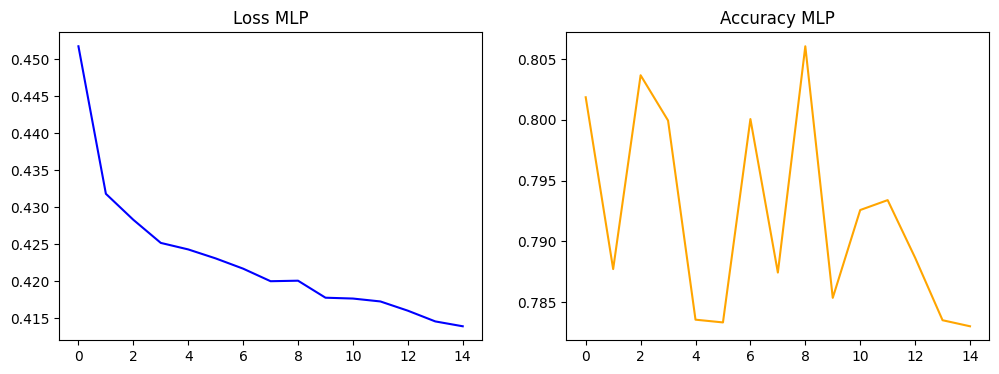

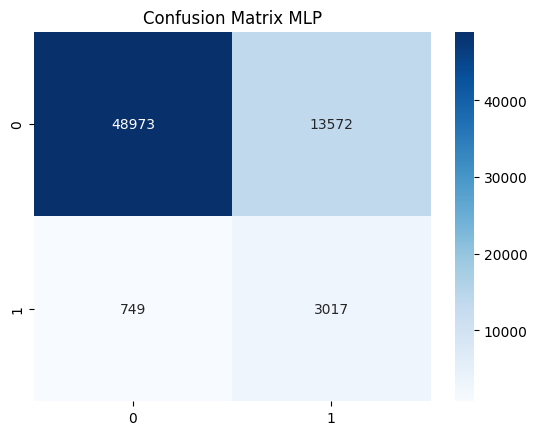

In [9]:
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = torch.max(mlp_model(X_test_t), 1)[1].cpu().numpy()

print("EVALUASI MODEL 1: BASE MLP")
print(classification_report(y_test, y_pred_mlp))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history['loss'], color='blue')
plt.title('Loss MLP')
plt.subplot(1, 2, 2)
plt.plot(mlp_history['acc'], color='orange')
plt.title('Accuracy MLP')
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix MLP')
plt.show()

# 6 Tabnet

## 6.1 Train Model

In [10]:
tabnet_pretrainer = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'
)

tabnet_pretrainer.fit(
    X_train=X_train_scaled.astype(np.float32),
    eval_set=[X_val_scaled.astype(np.float32)],
    max_epochs=10,
    patience=3,
    batch_size=1024,
    virtual_batch_size=128
)

tabnet_model = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":5, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'
)

tabnet_model.fit(
    X_train=X_train_scaled.astype(np.float32), 
    y_train=y_train.values.astype(np.int64),
    eval_set=[(X_val_scaled.astype(np.float32), y_val.values.astype(np.int64))],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=15,
    patience=5,
    batch_size=1024,
    virtual_batch_size=128,
    from_unsupervised=tabnet_pretrainer,
    weights=1
)

C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00942 | val_0_unsup_loss_numpy: 0.8251100182533264|  0:00:21s
epoch 1  | loss: 0.90025 | val_0_unsup_loss_numpy: 0.7587500214576721|  0:00:43s
epoch 2  | loss: 0.87902 | val_0_unsup_loss_numpy: 0.7339800000190735|  0:01:05s
epoch 3  | loss: 0.87201 | val_0_unsup_loss_numpy: 0.7341399788856506|  0:01:27s
epoch 4  | loss: 0.87113 | val_0_unsup_loss_numpy: 0.7184100151062012|  0:01:49s
epoch 5  | loss: 0.86858 | val_0_unsup_loss_numpy: 0.7206900119781494|  0:02:11s
epoch 6  | loss: 0.8666  | val_0_unsup_loss_numpy: 0.722350001335144|  0:02:32s
epoch 7  | loss: 0.86645 | val_0_unsup_loss_numpy: 0.7163400053977966|  0:02:57s
epoch 8  | loss: 0.86477 | val_0_unsup_loss_numpy: 0.7163800001144409|  0:03:20s
epoch 9  | loss: 0.86285 | val_0_unsup_loss_numpy: 0.7152500152587891|  0:03:43s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_unsup_loss_numpy = 0.7152500152587891


C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.48606 | valid_accuracy: 0.78392 |  0:00:17s
epoch 1  | loss: 0.43227 | valid_accuracy: 0.8249  |  0:00:35s
epoch 2  | loss: 0.43123 | valid_accuracy: 0.81568 |  0:00:53s
epoch 3  | loss: 0.42373 | valid_accuracy: 0.78788 |  0:01:12s
epoch 4  | loss: 0.4229  | valid_accuracy: 0.77919 |  0:01:30s
epoch 5  | loss: 0.41975 | valid_accuracy: 0.78474 |  0:01:47s
epoch 6  | loss: 0.41916 | valid_accuracy: 0.8092  |  0:02:04s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_valid_accuracy = 0.8249


C:\Users\an466\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## 6.2 Evaluasi Model

EVALUASI MODEL 2: TABNET PRETRAINED
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     62545
           1       0.21      0.76      0.33      3766

    accuracy                           0.83     66311
   macro avg       0.60      0.79      0.62     66311
weighted avg       0.94      0.83      0.87     66311



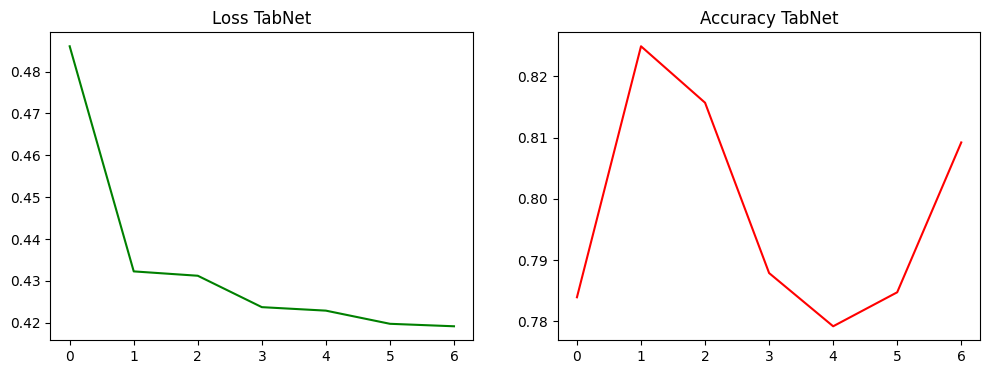

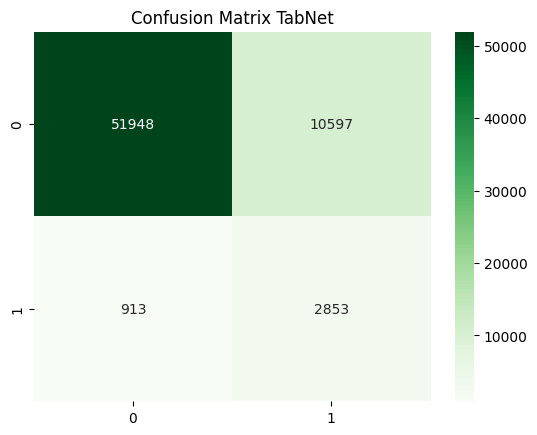

In [11]:
y_pred_tabnet = tabnet_model.predict(X_test_scaled.astype(np.float32))

print("EVALUASI MODEL 2: TABNET PRETRAINED")
print(classification_report(y_test, y_pred_tabnet))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(tabnet_model.history['loss'], color='green')
plt.title('Loss TabNet')
plt.subplot(1, 2, 2)
plt.plot(tabnet_model.history['valid_accuracy'], color='red')
plt.title('Accuracy TabNet')
plt.show()

sns.heatmap(confusion_matrix(y_test, y_pred_tabnet), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix TabNet')
plt.show()

# 7. Pretrained Embedding + Neural Network

## 7.1 Train Model

In [18]:
class FTTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=32, n_heads=4, n_layers=2):
        super(FTTransformer, self).__init__()
        self.tokenizer = nn.ModuleList([nn.Linear(1, embed_dim) for _ in range(input_dim)])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=n_heads, 
            dim_feedforward=128, 
            batch_first=True,
            dropout=0.2
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.head = nn.Linear(embed_dim, 2)
        
    def forward(self, x):
        tokens = [self.tokenizer[i](x[:, i].unsqueeze(-1)) for i in range(x.shape[1])]
        x = torch.stack(tokens, dim=1)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.transformer(x)
        return self.head(x[:, 0])

ft_model = FTTransformer(X_train_scaled.shape[1]).to(device)
optimizer_ft = optim.Adam(ft_model.parameters(), lr=0.0005)
ft_history = {'loss': [], 'val_acc': []}



In [19]:
for epoch in range(15):
    ft_model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer_ft.zero_grad()
        outputs = ft_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_ft.step()
        total_loss += loss.item()
    
    ft_model.eval()
    with torch.no_grad():
        val_outputs = ft_model(X_val_t)
        val_preds = torch.max(val_outputs, 1)[1]
        val_acc = (val_preds == y_val_t).float().mean().item()
    
    ft_history['loss'].append(total_loss/len(train_loader))
    ft_history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/15 - Loss: {ft_history['loss'][-1]:.4f} - Val Acc: {val_acc:.4f}")

Epoch 1/15 - Loss: 0.4910 - Val Acc: 0.8615
Epoch 2/15 - Loss: 0.4443 - Val Acc: 0.8298
Epoch 3/15 - Loss: 0.4372 - Val Acc: 0.8305
Epoch 4/15 - Loss: 0.4349 - Val Acc: 0.7704
Epoch 5/15 - Loss: 0.4327 - Val Acc: 0.7817
Epoch 6/15 - Loss: 0.4307 - Val Acc: 0.8267
Epoch 7/15 - Loss: 0.4307 - Val Acc: 0.8253
Epoch 8/15 - Loss: 0.4290 - Val Acc: 0.8068
Epoch 9/15 - Loss: 0.4287 - Val Acc: 0.7571
Epoch 10/15 - Loss: 0.4282 - Val Acc: 0.7779
Epoch 11/15 - Loss: 0.4280 - Val Acc: 0.8008
Epoch 12/15 - Loss: 0.4269 - Val Acc: 0.8353
Epoch 13/15 - Loss: 0.4265 - Val Acc: 0.7961
Epoch 14/15 - Loss: 0.4264 - Val Acc: 0.8178
Epoch 15/15 - Loss: 0.4264 - Val Acc: 0.7872


## 7.2. Evaluasi Model

EVALUASI MODEL 3: FT-TRANSFORMER
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     62545
           1       0.19      0.81      0.30      3766

    accuracy                           0.79     66311
   macro avg       0.59      0.80      0.59     66311
weighted avg       0.94      0.79      0.84     66311



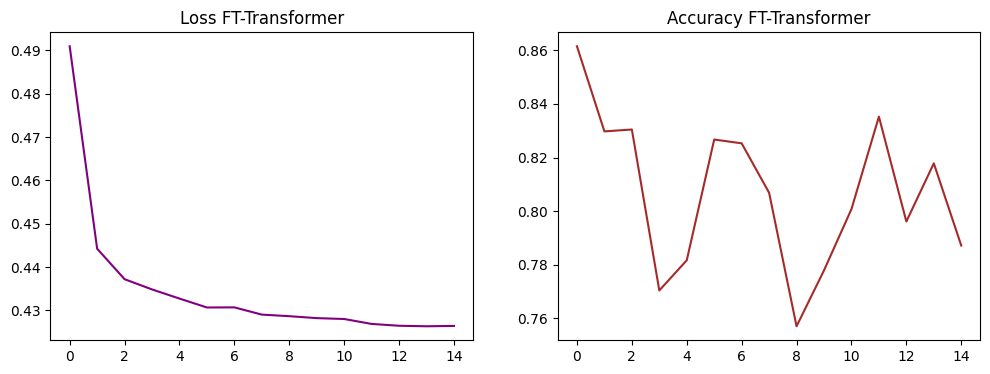

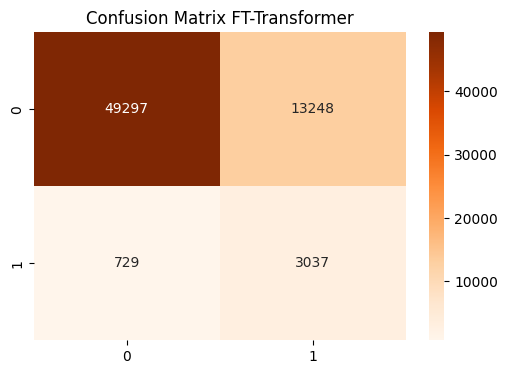

In [24]:
ft_model.eval()
with torch.no_grad():
    y_pred_ft = torch.max(ft_model(X_test_t), 1)[1].cpu().numpy()

print("EVALUASI MODEL 3: FT-TRANSFORMER")
print(classification_report(y_test, y_pred_ft))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ft_history['loss'], color='purple')
plt.title('Loss FT-Transformer')
plt.subplot(1, 2, 2)
plt.plot(ft_history['val_acc'], color='brown')
plt.title('Accuracy FT-Transformer')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_ft), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix FT-Transformer')
plt.show()

# 8 Build Model untuk Streamlit

In [22]:
import os
import joblib
import torch

os.makedirs('src/models', exist_ok=True)
joblib.dump(X.columns.tolist(), 'src/models/feature_names.pkl')

df_raw = pd.read_csv('heart_2022_with_nans.csv')
clean_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    valid_labels = [str(x) for x in df_raw[col].dropna().unique()]
    le.fit(valid_labels)
    clean_encoders[col] = le

joblib.dump(clean_encoders, 'src/models/label_encoders.pkl')
joblib.dump(scaler, 'src/models/scaler.pkl')

torch.save(mlp_model.state_dict(), 'src/models/mlp_model.pth')
torch.save(ft_model.state_dict(), 'src/models/ft_transformer_model.pth')
tabnet_model.save_model('src/models/tabnet_model')

Successfully saved model at src/models/tabnet_model.zip


'src/models/tabnet_model.zip'